In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

plots_dir = 'src/data/outputs/plots/game_theory/stability_PD'
games_names = ["prisoners_dilemma"] #pd, generic...

In [22]:
#columns = model_name,personality_1,personality_2,agent_1_scores,agent_2_scores,agent_1_messages,agent_2_messages,agent_1_actions,agent_2_actions,total_rounds

folder_path = "src/data/outputs/"
files_in_folder = os.listdir(folder_path)
list_of_files = [x for x in files_in_folder if x.endswith("solved.csv")]
list_of_files = [x for x in list_of_files if any(game in x for game in games_names)]
run_ids = [x.split("_solved.csv")[0].split("_")[-1] for x in list_of_files]
dfs = []
games = [x.split("_" + run_ids[i])[0] for i,x in enumerate(list_of_files)]


for i, csv_path in enumerate(list_of_files):
    full_path = os.path.join(folder_path, csv_path)
    df = pd.read_csv(full_path, converters={
        'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'total_rounds': int
    })
    df['game'] = games[i]
    df['run_id'] = run_ids[i]
    #game names are before the run_ids
    dfs.append(df)
df = pd.concat(dfs)
    

df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

#parse as lists, something went wrong when saving the csv
df['truthful_agent_1'] = df['truthful_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['truthful_agent_2'] = df['truthful_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Parse the actions as lists of strings
df['agent_1_actions'] = df['agent_1_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_actions'] = df['agent_2_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_1_messages'] = df['agent_1_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_messages'] = df['agent_2_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_1'] = df['intent_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_2'] = df['intent_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the average cost per round for each row
df['cost_per_round'] = df['total_cost_USD'] / df['total_rounds']

unique_games = df['game'].unique()
unique_games_str = '__'.join(unique_games)
print(unique_games_str)


# Extract final scores for both agents
df['final_score_agent_1'] = df['agent_1_cumulative_scores'].apply(lambda x: x[-1])
df['final_score_agent_2'] = df['agent_2_cumulative_scores'].apply(lambda x: x[-1])

# Combine into one DataFrame for analysis
final_scores_df = pd.DataFrame({
    'Personality': df['personality_1'].tolist() + df['personality_2'].tolist(),
    'Final Score': df['final_score_agent_1'].tolist() + df['final_score_agent_2'].tolist()
})

# Compute mean final score
mean_final_score = final_scores_df['Final Score'].mean()

# Optional: Total score per personality for x-tick labels
total_scores_dict = final_scores_df.groupby('Personality')['Final Score'].sum().to_dict()

prisoners_dilemma


## plot the final scores of each agent of each game

In [23]:

import numpy as np
# Define your desired order: all experimental personalities first, then a gap, then control groups
experimental_personalities = [p for p in final_scores_df['Personality'].unique() if p not in ['ALTRUISTIC', 'NONE', 'SELFISH']]
control_groups = ['ALTRUISTIC', 'NONE', 'SELFISH']
ordered_personalities = experimental_personalities + [''] + control_groups

# Add a dummy row to enable the empty x-axis label for spacing
dummy_row = pd.DataFrame({'Personality': [''], 'Final Score': [np.nan]})
plot_df = pd.concat([final_scores_df, dummy_row], ignore_index=True)

# Update xtick labels accordingly
total_scores_dict[''] = ''  # prevent KeyError for empty label
xticks_labels = [f"{p[:4]}\n{total_scores_dict[p]}" if p else "" for p in ordered_personalities]

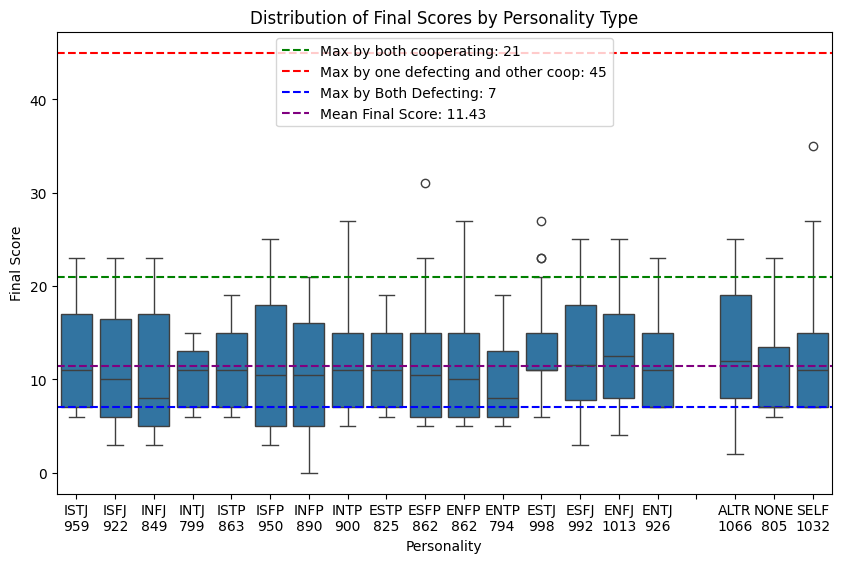

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Personality', y='Final Score', order=ordered_personalities)
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend(loc='upper center')
plt.title('Distribution of Final Scores by Personality Type')
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)
plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.savefig(f"{plots_dir}/boxplot_final_scores_{unique_games_str}.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1956368/1401298461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Personality', y='Final Score', inner='quartile', palette='Set3', order=ordered_personalities)


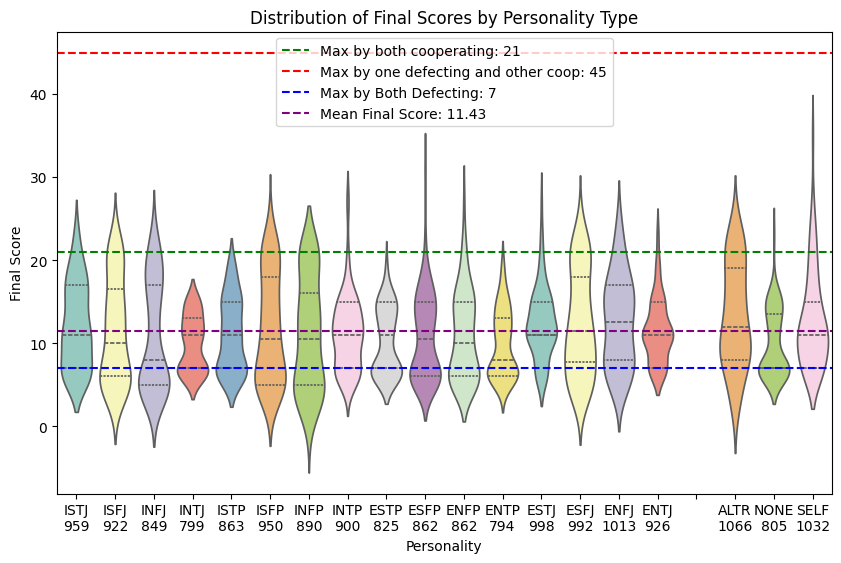

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='Personality', y='Final Score', inner='quartile', palette='Set3', order=ordered_personalities)
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend(loc='upper center')
plt.title('Distribution of Final Scores by Personality Type')
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)
plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.savefig(f"{plots_dir}/distribution_final_scores_4_runs.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1956368/349441311.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='I/E', y='Final Score', inner='quartile', palette='Set2')
/tmp/ipykernel_1956368/349441311.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='N/S', y='Final Score', inner='quartile', palette='Set2')
/tmp/ipykernel_1956368/349441311.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='T/F', y='Final Score', inner='quartile', palette='Set2')
/tmp/ipykernel_1956368/349441311.py:3

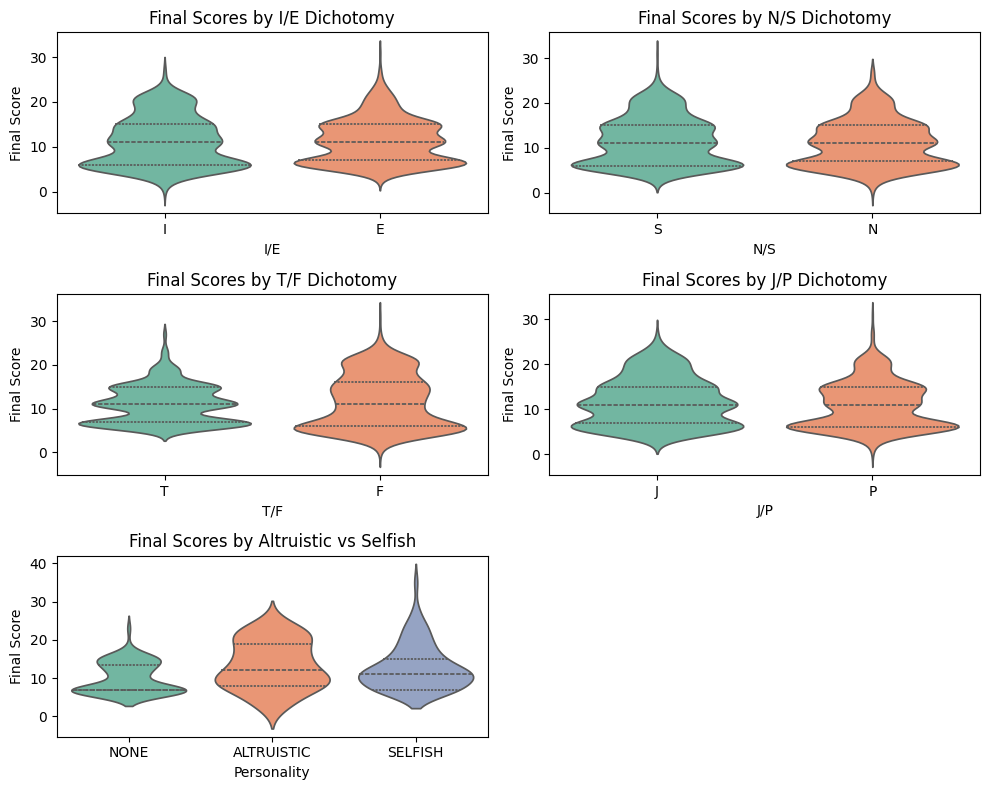

In [26]:
# Filter out the control groups
filtered_df = final_scores_df[~final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Final Score'] = filtered_df['Final Score']

# Add NONE, ALTRUISTIC, and SELFISH to the dichotomies DataFrame
control_df = final_scores_df[final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
control_df['I/E'] = 'NONE'
control_df['N/S'] = 'NONE'
control_df['T/F'] = 'NONE'
control_df['J/P'] = 'NONE'

# Plot the violin plots for each dichotomy
plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Final Score', inner='quartile', palette='Set2')
plt.title('Final Scores by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Final Score', inner='quartile', palette='Set2')
plt.title('Final Scores by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Final Score', inner='quartile', palette='Set2')
plt.title('Final Scores by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Final Score', inner='quartile', palette='Set2')
plt.title('Final Scores by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=control_df, x='Personality', y='Final Score', inner='quartile', palette='Set2')
plt.title('Final Scores by Altruistic vs Selfish')

plt.tight_layout()
plt.savefig(f"{plots_dir}/dichotomies_violin_final_scores.png", dpi=300, bbox_inches='tight')
plt.show()


## plot mean cummulative scores
some scores that start of strong, end up worse than others: guessing because agents don t tolerate repeated lying and then just defect each round as well.
Maybe with a alonger game, the difference would be even more clear.

Personality: NONE, Mean Cumulative Scores: [0.0, 2.4375, 4.7625, 6.0125, 7.0625, 8.0625, 9.0625, 10.0625]
Personality: ISTJ, Mean Cumulative Scores: [0.0, 2.430379746835443, 4.620253164556962, 6.430379746835443, 8.253164556962025, 9.810126582278482, 11.050632911392405, 12.139240506329115]
Personality: ISFJ, Mean Cumulative Scores: [0.0, 1.9125, 3.7625, 5.6, 7.325, 8.875, 10.325, 11.525]
Personality: INFJ, Mean Cumulative Scores: [0.0, 1.5384615384615385, 3.1025641025641026, 4.871794871794871, 6.666666666666667, 8.346153846153847, 9.73076923076923, 10.884615384615385]
Personality: INTJ, Mean Cumulative Scores: [0.0, 2.7125, 4.8875, 5.9875, 6.9875, 7.9875, 8.9875, 9.9875]
Personality: ISTP, Mean Cumulative Scores: [0.0, 2.551282051282051, 4.6923076923076925, 6.576923076923077, 7.910256410256411, 9.064102564102564, 10.064102564102564, 11.064102564102564]
Personality: ISFP, Mean Cumulative Scores: [0.0, 2.025, 3.775, 5.65, 7.3625, 8.9375, 10.475, 11.875]
Personality: INFP, Mean Cumulative 

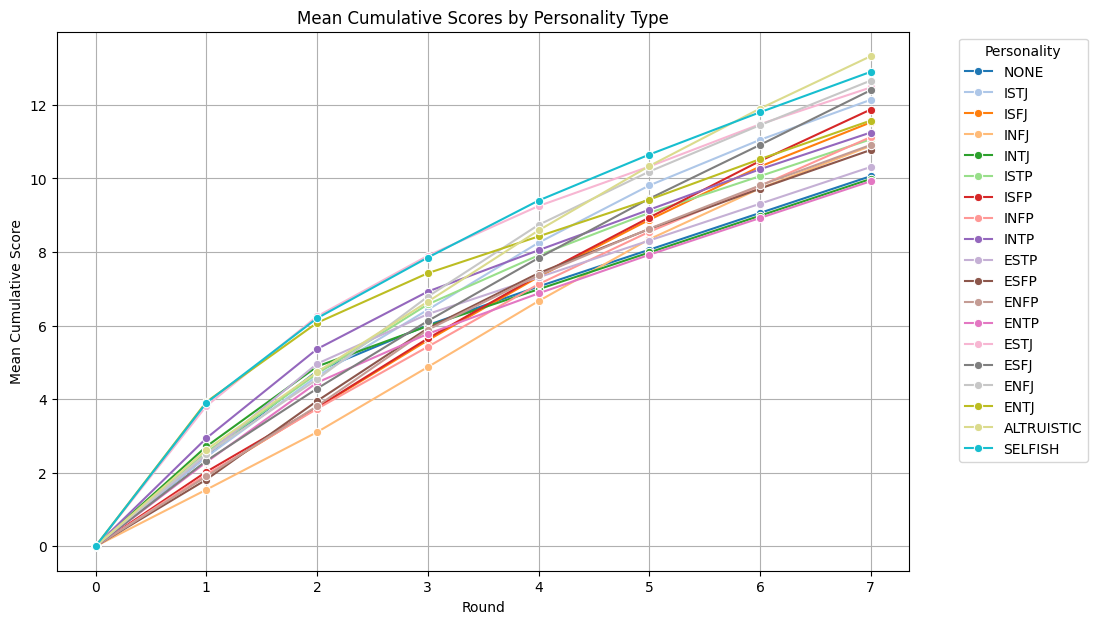

In [27]:
from collections import defaultdict

# Initialize a dictionary to store cumulative scores by personality
cumulative_scores_by_personality = defaultdict(list)

# Iterate through the dataframe and collect cumulative scores
for i, row in df.iterrows():
    for personality, scores in zip([row['personality_1'], row['personality_2']], [row['agent_1_cumulative_scores'], row['agent_2_cumulative_scores']]):
        cumulative_scores_by_personality[personality].append(scores)

# Calculate the mean cumulative scores for each personality
mean_cumulative_scores_by_personality = {}
for personality, scores_list in cumulative_scores_by_personality.items():
    # Transpose the list of scores to calculate the mean for each round
    transposed_scores = list(zip(*scores_list))
    mean_cumulative_scores = [sum(scores) / len(scores) for scores in transposed_scores]
    mean_cumulative_scores_by_personality[personality] = mean_cumulative_scores

# Print the mean cumulative scores for each personality
for personality, mean_scores in mean_cumulative_scores_by_personality.items():
    print(f"Personality: {personality}, Mean Cumulative Scores: {mean_scores}")
    
    # Create a DataFrame for plotting
    plot_data = []
    for personality, mean_scores in mean_cumulative_scores_by_personality.items():
        for round_num, score in enumerate(mean_scores):
            plot_data.append({'Personality': personality, 'Round': round_num, 'Mean Cumulative Score': score})

plot_df = pd.DataFrame(plot_data)

# Plot the mean cumulative scores for each personality
plt.figure(figsize=(11, 7))
sns.lineplot(data=plot_df, x='Round', y='Mean Cumulative Score', hue='Personality', palette='tab20', marker='o')
plt.title('Mean Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Mean Cumulative Score')
plt.legend(title='Personality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(f"{plots_dir}/mean_cumulative_scores_by_personality.png", dpi=300, bbox_inches='tight')
plt.show()

# truthfulness
- the altruitic is not much higher, because sometimes the other agent says it will defect and it defects. while the altruistic then wants to stick to the positive message but still mirrors the others aciton,
- this could be explained by different reasons: the prompt is way shorter, so it s not as strong/easy to follow for the agent
- maybe rename to honest

/tmp/ipykernel_1956368/3141922842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2', order=ordered_personalities)


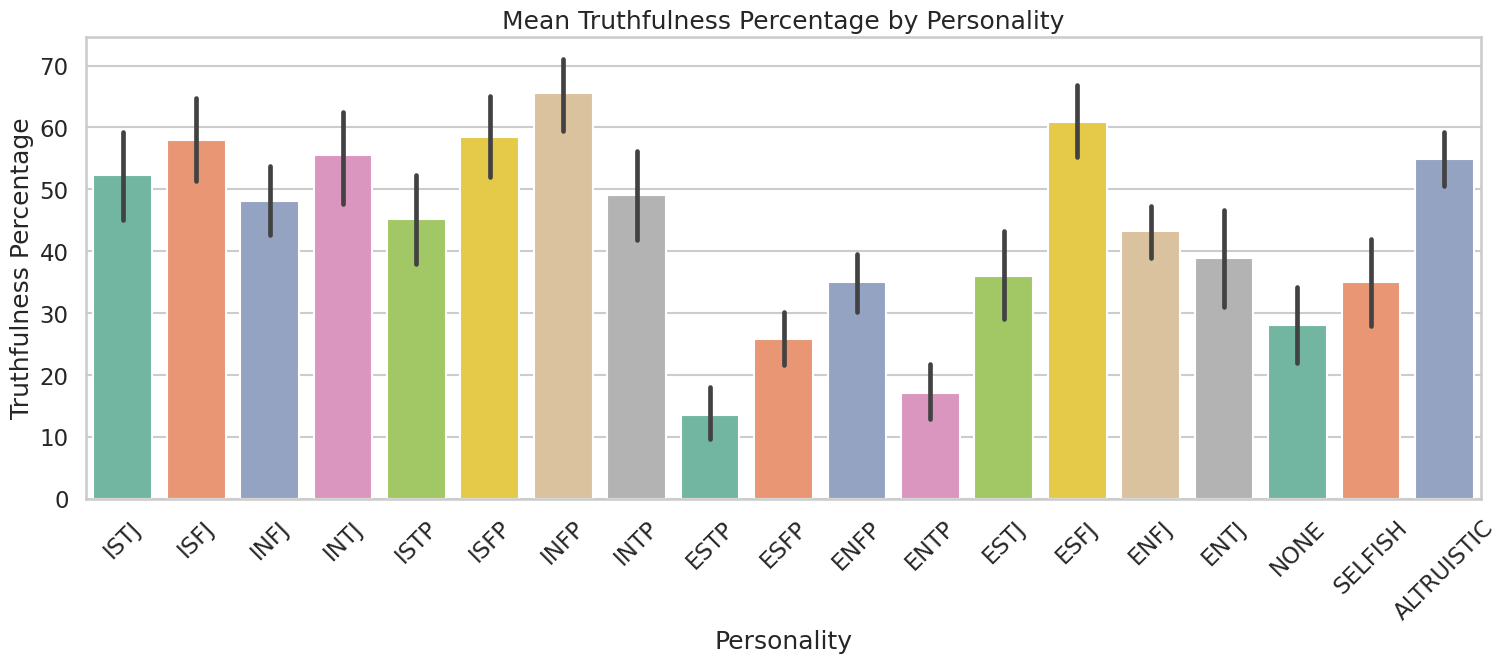

In [56]:
# Define the order for the personalities, with control groups at the end
ordered_personalities = [p for p in truthfulness_df['Personality'].unique() if p not in ['NONE', 'SELFISH', 'ALTRUISTIC']] + ['NONE', 'SELFISH', 'ALTRUISTIC']

# Plot the mean truthfulness percentage for each personality with the new order
plt.figure(figsize=(18, 6))
sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2', order=ordered_personalities)
plt.title('Mean Truthfulness Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Truthfulness Percentage')
plt.xticks(rotation=45)
plt.savefig(f"{plots_dir}/mean_truthfulness_4_runs.png", dpi=300, bbox_inches='tight')
plt.show()


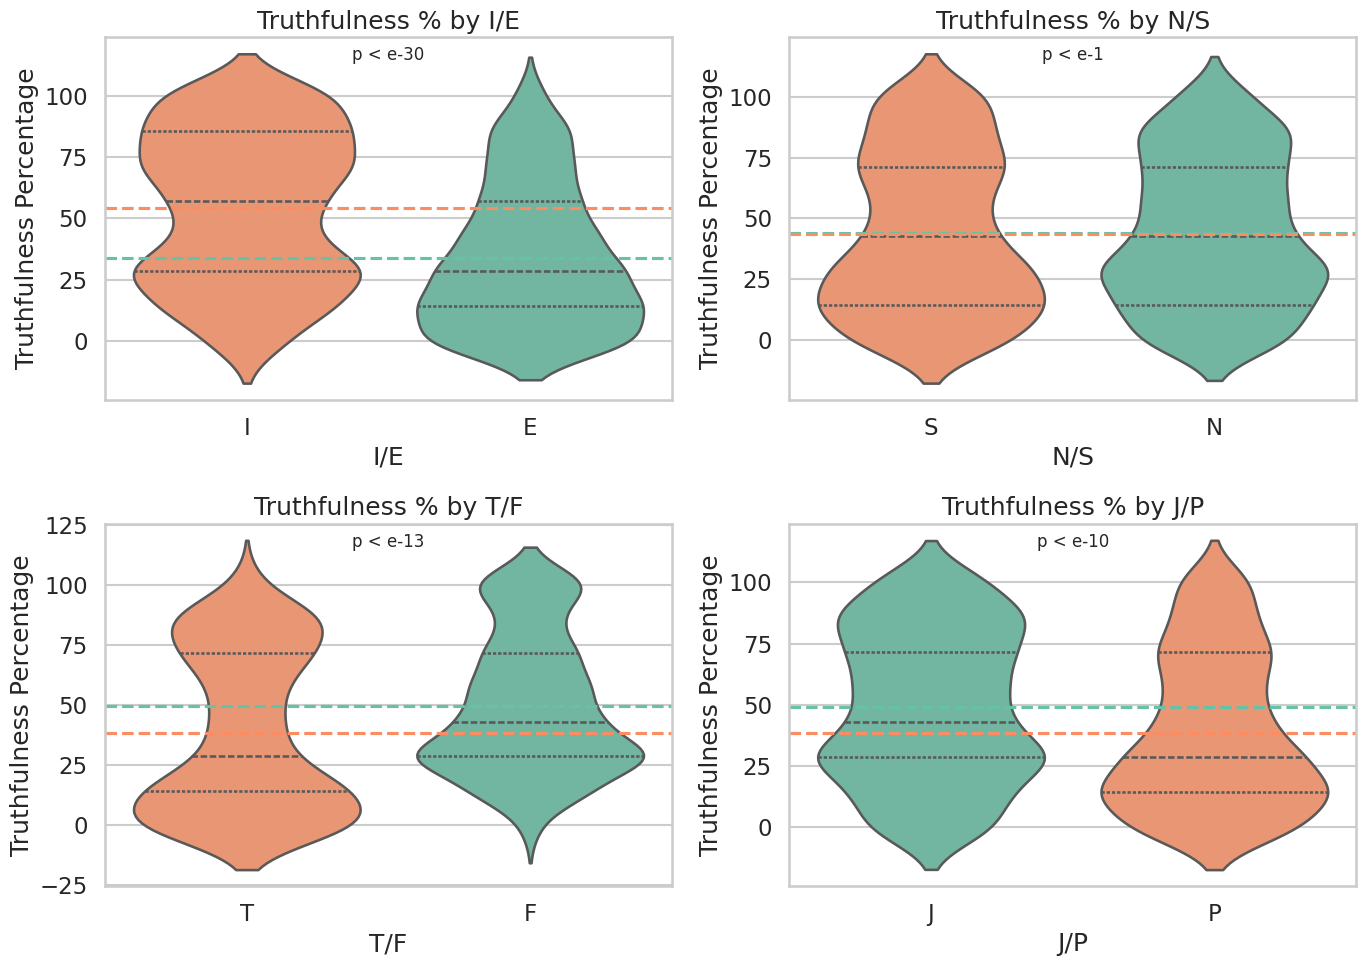

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Palette and helper setup
sns.set(style="whitegrid", context="talk")
palette = sns.color_palette("Set2")
color1, color2 = palette[0], palette[1]

# Helper for p-value annotation
def annotate_p(ax, group1, group2):
    try:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        exponent = int(np.floor(np.log10(p)))
        p_text = f"p < e{exponent}"
    except Exception:
        p_text = "p = error"
    ax.text(0.5, 0.95, p_text, ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Prepare dichotomy categories
filtered_df = truthfulness_df[~truthfulness_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
filtered_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
filtered_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
filtered_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
filtered_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')

# Plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Each plot
dichotomies = ['I/E', 'N/S', 'T/F', 'J/P']
titles = ['Truthfulness % by I/E', 'Truthfulness % by N/S',
          'Truthfulness % by T/F', 'Truthfulness % by J/P']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for d, title, pos in zip(dichotomies, titles, positions):
    ax = axs[pos]
    sns.violinplot(data=filtered_df, x=d, y='Truthfulness Percentage', inner='quartile',
                   hue=d, hue_order=sorted(filtered_df[d].unique()),
                   palette=[color1, color2], ax=ax, dodge=False)

    # Dashed lines for mean
    for group, color in zip(sorted(filtered_df[d].unique()), [color1, color2]):
        mean_val = filtered_df[filtered_df[d] == group]['Truthfulness Percentage'].mean()
        ax.axhline(mean_val, color=color, linestyle='--')

    # p-value annotation
    group1 = filtered_df[filtered_df[d] == sorted(filtered_df[d].unique())[0]]['Truthfulness Percentage']
    group2 = filtered_df[filtered_df[d] == sorted(filtered_df[d].unique())[1]]['Truthfulness Percentage']
    annotate_p(ax, group1, group2)

    ax.set_title(title)

plt.tight_layout()
#plt.savefig(f"{plots_dir}/dichotomies_violin_truthfulness_percentage_with_pvalues.png", dpi=300, bbox_inches='tight')
plt.show()


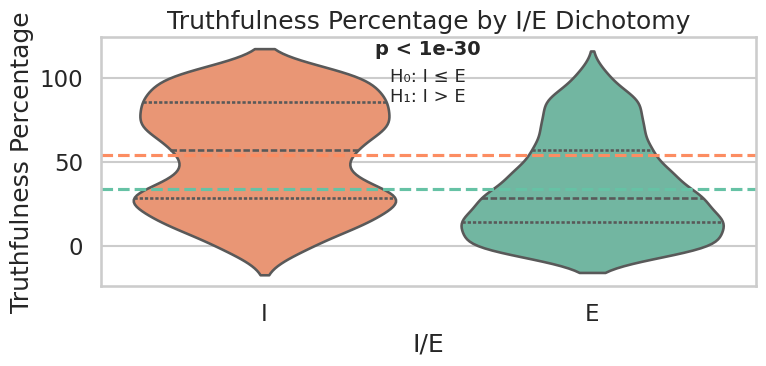

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Set style
sns.set(style="whitegrid", context="talk")
palette = sns.color_palette("Set2")
color1, color2 = palette[0], palette[1]

# Helper for one-sided p-value annotation (H₀: I ≤ E, H₁: I > E)
def annotate_p_directional_one_sided(ax, group1, group2):
    try:
        # One-sided Mann-Whitney U test
        stat, p = mannwhitneyu(group1, group2, alternative='greater')  # Tests if I > E

        # Format p-value
        p_text = f"p < 1e{int(np.floor(np.log10(p)))}" if p < 0.05 else f"p = {p:.3f}"
        explanation = "H₀: I ≤ E\nH₁: I > E"

    except Exception:
        p_text = "p = error"
        explanation = "Error in statistical test"

    # Annotate plot
    ax.text(0.5, 0.95, p_text, ha='center', va='center', transform=ax.transAxes, fontsize=14, weight='bold')
    ax.text(0.5, 0.80, explanation, ha='center', va='center', transform=ax.transAxes, fontsize=13)

# Filter and derive I/E
filtered_df = truthfulness_df[~truthfulness_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
filtered_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')

# Create plot
plt.figure(figsize=(8, 4))
ax = sns.violinplot(data=filtered_df, x='I/E', y='Truthfulness Percentage', inner='quartile',
                    hue='I/E', hue_order=['I', 'E'], palette=[color2, color1], dodge=False)

# Mean lines
mean_i = filtered_df[filtered_df['I/E'] == 'I']['Truthfulness Percentage'].mean()
mean_e = filtered_df[filtered_df['I/E'] == 'E']['Truthfulness Percentage'].mean()
ax.axhline(mean_i, color=color2, linestyle='--')
ax.axhline(mean_e, color=color1, linestyle='--')

# Annotate p-value and hypothesis
group_i = filtered_df[filtered_df['I/E'] == 'I']['Truthfulness Percentage']
group_e = filtered_df[filtered_df['I/E'] == 'E']['Truthfulness Percentage']
annotate_p_directional_one_sided(ax, group_i, group_e)

# Finalize plot
plt.title('Truthfulness Percentage by I/E Dichotomy')
plt.tight_layout()

# Save to file
plt.savefig(f"{plots_dir}/ie_dichotomy_violin_truthfulness.png", dpi=300, bbox_inches='tight')
plt.show()


# who lied first
- often, the agent stop being truthful because they keep getting lied to
- which is why i caught some pointers to show if the agent lied first in each conversation.
- we ignore the cases when the other agent defects first, even if they are being truthful about the fact theat they will defect.
- to explain why it looks like altruistic would lie ,first, but it s just a consequence of the other saying they will defect explictly.

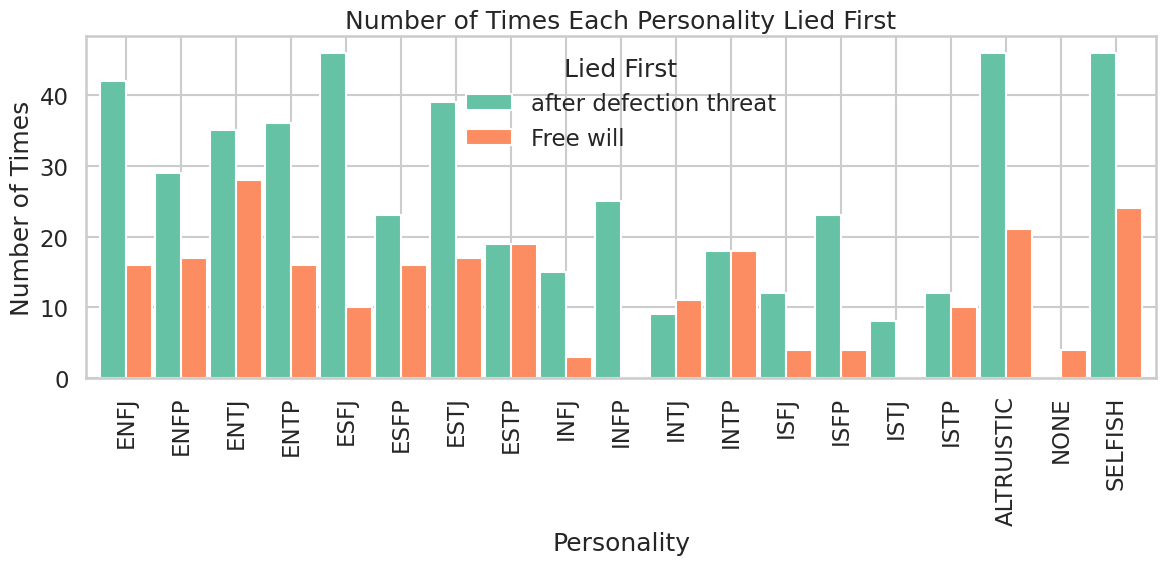

In [50]:
df['lied_first_1'] = [False] * len(df)
df['lied_first_2'] = [False] * len(df)
df['defected_first_1'] = [False] * len(df)
df['defected_first_2'] = [False] * len(df)

for i, row in df.iterrows():
    personality_1 = row['personality_1']
    personality_2 = row['personality_2']
    
    for truthful_1, truthful_2, intent_1, intent_2 in zip(row['truthful_agent_1'], row['truthful_agent_2'], row['intent_agent_1'], row['intent_agent_2']):
        if (truthful_1 == False) and (truthful_2 == True):
            df.at[i, 'lied_first_1'] = True
            break
        elif (truthful_1 == True) and (truthful_2 == False):
            df.at[i, 'lied_first_2'] = True
            break
    for action_1, action_2 in zip(row['agent_1_actions'], row['agent_2_actions']):
        if (action_1 == 'defect') and (action_2 == 'cooperate'):
            
            df.at[i, 'defected_first_1'] = True
            break
        elif (action_1 == 'cooperate') and (action_2 == 'defect'):
            df.at[i, 'defected_first_2'] = True
            break
        elif (action_1 == 'defect') and (action_2 == 'defect'):
            if (intent_1 == 'defect') and (intent_2 == 'cooperate'):
                df.at[i, 'defected_first_2'] = True
                break
            elif (intent_1 == 'cooperate') and (intent_2 == 'defect'):
                df.at[i, 'defected_first_1'] = True
                break
# Calculate the percentage of times each personality lied first
first_liars = df.groupby('personality_1')['lied_first_1'].sum().to_dict()
first_liars.update(df.groupby('personality_2')['lied_first_2'].sum().to_dict())

# Calculate the number of times each personality lied first and whether it was a consequence of being defected first
first_liars_consequence = df.groupby('personality_1')['defected_first_2'].sum().to_dict()
first_liars_consequence.update(df.groupby('personality_2')['defected_first_1'].sum().to_dict())

# Calculate the number of times each personality lied first without being defected first
first_liars_no_consequence = {k: abs(first_liars[k] - first_liars_consequence.get(k, 0)) for k in first_liars.keys()}

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Personality': list(first_liars.keys()),
    'after defection threat': list(first_liars_consequence.values()),
    'Free will': list(first_liars_no_consequence.values())
})
# Personalities to move to the right
controls = ['NONE', 'ALTRUISTIC', 'SELFISH']

# Split plot_data into main and control groups
main_data = plot_data[~plot_data['Personality'].isin(controls)].copy()
control_data = plot_data[plot_data['Personality'].isin(controls)].copy()

# Optional: sort main data alphabetically (or however you prefer)
main_data = main_data.sort_values('Personality')

# Concatenate with control personalities at the end
ordered_plot_data = pd.concat([main_data, control_data], axis=0)

# Use the Set2 palette (same as earlier violin plots)
colors = sns.color_palette("Set2", n_colors=2)

# Plot the bars side-by-side (grouped) with Set2 colors and wider bars
ax = ordered_plot_data.set_index('Personality').plot(
    kind='bar',
    stacked=False,
    width=0.95,
    figsize=(12, 6),
    color=colors
)

plt.title('Number of Times Each Personality Lied First')
plt.xlabel('Personality')
plt.ylabel('Number of Times')

# Move legend to upper center inside the plot
ax.legend(
    title='Lied First',
    loc='upper center',
    frameon=False
)

plt.tight_layout()
plt.savefig(f"{plots_dir}/first_liars_all.png", dpi=300, bbox_inches='tight')
plt.show()


## truthfulness
- truthfullness is defined by how many times the agent said the truth/total actions
- maybe also compare when we take into account if the lies were by free will and not as a consequence of defection

In [31]:
def calculate_how_truthfull(list_bools):
    return sum(list_bools) / len(list_bools)

# Extract the last value of cumulative scores and truthfulness for each agent
df['agent_1_final_score'] = df['agent_1_cumulative_scores'].apply(lambda x: x[-1])
df['agent_2_final_score'] = df['agent_2_cumulative_scores'].apply(lambda x: x[-1])
df['agent_1_final_truthfulness'] = df['truthful_agent_1'].apply(lambda x: calculate_how_truthfull(x))
df['agent_2_final_truthfulness'] = df['truthful_agent_2'].apply(lambda x: calculate_how_truthfull(x))

# Create a new DataFrame to store the correlation data
correlation_data = []

# Iterate through the dataframe and collect the necessary data
for i, row in df.iterrows():
    correlation_data.append({
        'Personality': row['personality_1'],
        'Final Score': row['agent_1_final_score'],
        'Truthfulness': row['agent_1_final_truthfulness']
    })
    correlation_data.append({
        'Personality': row['personality_2'],
        'Final Score': row['agent_2_final_score'],
        'Truthfulness': row['agent_2_final_truthfulness']
    })

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data)
correlation_df_groups = correlation_df.groupby('Personality').sum().reset_index()

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(correlation_df_groups[['Truthfulness']], correlation_df_groups[['Final Score']])

correlation_df_groups['Predicted Final Score'] = reg.predict(correlation_df_groups[['Truthfulness']])
correlation_df_groups

,Personality,Final Score,Truthfulness,Predicted Final Score
0,ALTRUISTIC,1066,43.857143,937.653839
1,ENFJ,1013,34.571429,911.321177
2,ENFP,862,27.714286,891.875518
3,ENTJ,926,31.142857,901.598348
4,ENTP,794,13.714286,852.173966
5,ESFJ,992,48.714286,951.427847
6,ESFP,862,20.714286,872.024742
7,ESTJ,998,28.857143,895.116461
8,ESTP,825,10.857143,844.071608
9,INFJ,849,37.571429,919.828652


## Linear Regression
- by making a linear regression, we can see how being more truthful, we get better scores
- to have a real simulation, we d need to also take into account the amount of population in each group. for the games.
- We can adda weight factor for that.
- our data assumes that there are as many of each type right now

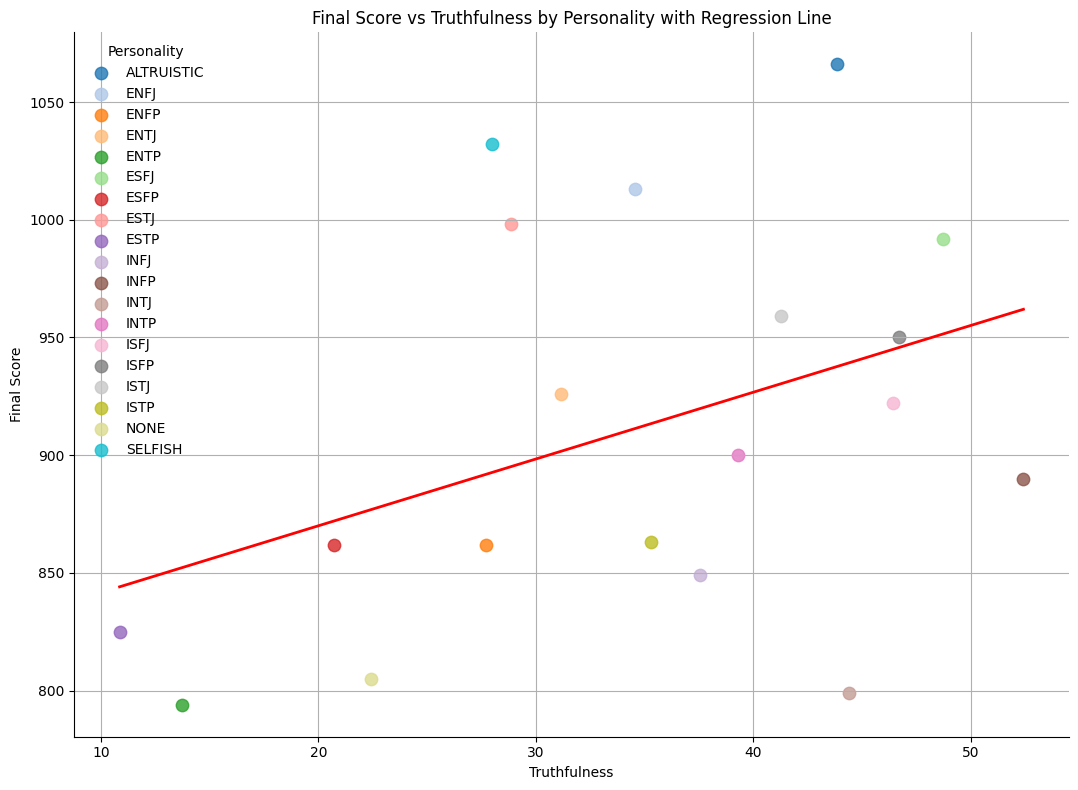

In [ ]:
# Create the lmplot
g = sns.lmplot(
    data=correlation_df_groups,
    x='Truthfulness',
    y='Final Score',
    hue='Personality',
    aspect=1.2,
    height=8,
    markers='o',
    palette='tab20',
    ci=None,
    scatter_kws={'s': 80}
)

# Add regression line to the same axis
ax = g.axes[0, 0]  # Access the underlying Matplotlib Axes from the FacetGrid
sns.lineplot(
    x=correlation_df_groups['Truthfulness'],
    y=correlation_df_groups['Predicted Final Score'],
    color='red',
    linewidth=2,
    ax=ax,
    legend=False 
)

# Set titles and labels
ax.set_title('Final Score vs Truthfulness by Personality with Regression Line')
ax.set_xlabel('Truthfulness')
ax.set_ylabel('Final Score')
ax.grid(True)

# Remove duplicate legends, just to be safe
g._legend.remove()

# Re-add only one clean legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig(f"{plots_dir}/final_score_vs_truthfulness.png", dpi=300, bbox_inches='tight')
plt.show()
